# Processing data

Many ML algorithms need data that is numeric, complete (no missing) and standardized. Ensembles of trees are the most accommodating and require the least data processing.

In [1]:
url = (
    'http://biostat.mc.vanderbilt.edu/' 
    'wiki/pub/Main/DataSets/titanic3.xls'
)

In [2]:
import pandas as pd

In [3]:
df = pd.read_excel(url)
df_orig = df.copy()

### Basic inspection

In [4]:
df.sample(5)

pclass  survived                           name     sex   age  sibsp  \
1117       3         0          Pekoniemi, Mr. Edvard    male  21.0      0   
412        2         0           Fynney, Mr. Joseph J    male  35.0      0   
64         1         1  Chambers, Mr. Norman Campbell    male  27.0      1   
650        3         0          Attalah, Miss. Malake  female  17.0      0   
912        3         0              Karaic, Mr. Milan    male  30.0      0   

      parch             ticket     fare cabin embarked boat   body  \
1117      0  STON/O 2. 3101294   7.9250   NaN        S  NaN    NaN   
412       0             239865  26.0000   NaN        S  NaN  322.0   
64        0             113806  53.1000    E8        S    5    NaN   
650       0               2627  14.4583   NaN        C  NaN    NaN   
912       0             349246   7.8958   NaN        S  NaN    NaN   

                      home.dest  
1117                        NaN  
412    Liverpool / Montreal, PQ  
64    New York, NY / Ithaca, NY  
650                         NaN  
912                         NaN

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


### Detailed inspection

In [6]:
import pandas_profiling as pp

In [7]:
pp.ProfileReport(df)

### Create new features

Sometimes we want to create new features from existing columns. For example, the names column can be mined to extract titles. We illustrate how to do this, but will not use this here.

In [8]:
df['title'] = df.name.str.extract('.*([A-Z][a-z]+)\..*')
df.title.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Major         2
Mlle          2
Ms            2
Don           1
Lady          1
Mme           1
Jonkheer      1
Sir           1
Capt          1
Dona          1
Countess      1
Name: title, dtype: int64

### Drop features

These features are either uninformative or leak information about the outcome.

In [9]:
target = df.survived
df = df.drop(columns = [
    'survived', 'name', 'ticket', 'cabin'
    ,'boat', 'body', 'home.dest', 'title'])

### Inspect for missing data

In [10]:
import missingno as mn

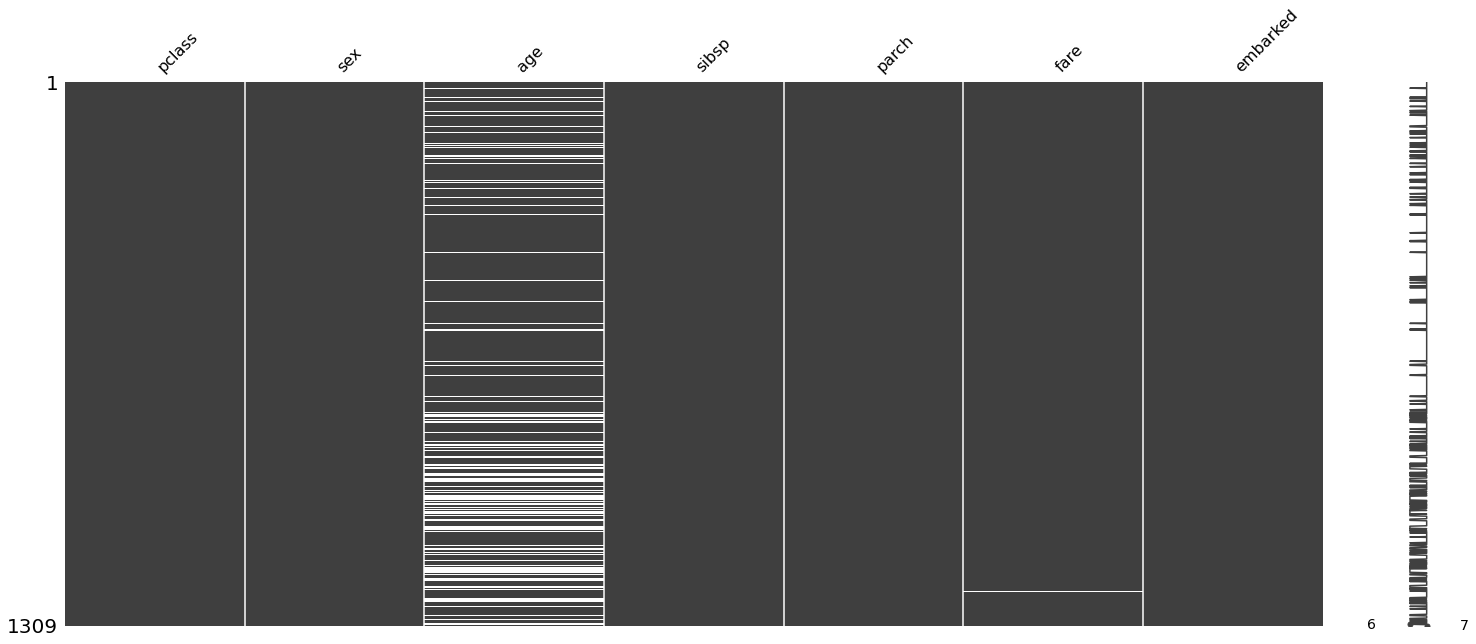

In [11]:
mn.matrix(df);

### Fill in missing values for categorical values

In [12]:
df.select_dtypes('object').isnull().sum()

sex         0
embarked    2
dtype: int64

In [13]:
df['embarked'] = df['embarked'].fillna('')

### Tangent:  `catboost` is nice

Minimal processing or tuning is required to use `catboost`, making it a nice "default" algorithm.

In [14]:
! python3 -m pip install --quiet catboost

In [15]:
import catboost

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test =train_test_split(df, target, random_state=0)

In [18]:
cb = catboost.CatBoostClassifier()

In [19]:
cb.fit(X_train, y_train, 
       cat_features=['sex', 'embarked'],
       verbose=0);

In [20]:
cb.score(X_test, y_test)

0.8170731707317073

### Category encoding

#### Vanilla encoding

For variables with only a few distinct values, one hot encoding (or dummy variables) is often used. For more values, we can use hash encoding, which is basically the same idea but bins values using a hash function.

We may choose to drop one of the created columns to avoid multicollinearity.

In [21]:
pd.get_dummies(df, drop_first=True).head()

pclass      age  sibsp  parch      fare  sex_male  embarked_C  embarked_Q  \
0       1  29.0000      0      0  211.3375         0           0           0   
1       1   0.9167      1      2  151.5500         1           0           0   
2       1   2.0000      1      2  151.5500         0           0           0   
3       1  30.0000      1      2  151.5500         1           0           0   
4       1  25.0000      1      2  151.5500         0           0           0   

   embarked_S  
0           1  
1           1  
2           1  
3           1  
4           1

#### Target encoding

We can use the target to find a more informative encoding. Note that these methods leak information and are prone to over-fitting.

In [22]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [23]:
import category_encoders as ce

In [24]:
te = ce.TargetEncoder()

In [25]:
te.fit_transform(df.select_dtypes('number'), target).head()

pclass      age  sibsp  parch      fare
0       1  29.0000      0      0  211.3375
1       1   0.9167      1      2  151.5500
2       1   2.0000      1      2  151.5500
3       1  30.0000      1      2  151.5500
4       1  25.0000      1      2  151.5500

### Split data into train and test data sets

Before we go further, we split into test and train data sets to avoid data leakage.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df, target)

### Category encoding

#### We will be conservative and avoid risk of leakage

Note we don't bother to drop columns - multicollinearity is only a problem when fitting linear models without regularization - this is rarely done in ML (c.f. statistics).

In [27]:
ohe= ce.OneHotEncoder(cols=['sex','embarked'], use_cat_names=True)

In [28]:
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

In [29]:
X_train.head()

pclass  sex_male  sex_female   age  sibsp  parch     fare  embarked_S  \
414        2         1           0  34.0      1      0  21.0000           1   
287        1         1           0  61.0      0      0  32.3208           1   
1279       3         0           1  14.0      0      0   7.8542           1   
711        3         1           0  28.0      0      0   7.2500           1   
358        2         0           1  42.0      0      0  13.0000           1   

      embarked_C  embarked_Q  embarked_  
414            0           0          0  
287            0           0          0  
1279           0           0          0  
711            0           0          0  
358            0           0          0

### Impute missing numeric values

#### Vanilla imputation

A simple imputation is to fill with mean or median.

In [30]:
from sklearn.impute import SimpleImputer

In [31]:
si = SimpleImputer(strategy='mean')

In [32]:
X_train.select_dtypes('number').head(3)

pclass  sex_male  sex_female   age  sibsp  parch     fare  embarked_S  \
414        2         1           0  34.0      1      0  21.0000           1   
287        1         1           0  61.0      0      0  32.3208           1   
1279       3         0           1  14.0      0      0   7.8542           1   

      embarked_C  embarked_Q  embarked_  
414            0           0          0  
287            0           0          0  
1279           0           0          0

We illustrate the code but will try more fancy imputation instead.

```python
X_train[X_train.select_dtypes('number').columns] = \
si.fit_transform(X_train.select_dtypes('number'))
X_test[X_test.select_dtypes('number').columns] = \
si.transform(X_test.select_dtypes('number'))
```

#### Fancy imputation

This basically does the same thing as `mice` in R.

In [33]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [34]:
ii = IterativeImputer(random_state=0)

In [35]:
X_train[X_train.select_dtypes('number').columns] = \
ii.fit_transform(X_train.select_dtypes('number'))

In [36]:
X_test[X_test.select_dtypes('number').columns] =  \
ii.transform(X_test.select_dtypes('number'))

In [37]:
X_train.isnull().sum().sum(), X_test.isnull().sum().sum()

(0, 0)

#### Simple example to illustrate differences

In [38]:
import numpy as np

In [39]:
x = np.array([
    [10, 10],
    [1, 1],
    [2,2],
    [10, 10],
    [10, np.nan],
    [np.nan, 10],
    [np.nan, np.nan]
])

In [40]:
si.fit_transform(x)

array([[10. , 10. ],
       [ 1. ,  1. ],
       [ 2. ,  2. ],
       [10. , 10. ],
       [10. ,  6.6],
       [ 6.6, 10. ],
       [ 6.6,  6.6]])

In [41]:
ii.fit_transform(x)

array([[10.        , 10.        ],
       [ 1.        ,  1.        ],
       [ 2.        ,  2.        ],
       [10.        , 10.        ],
       [10.        ,  9.99968523],
       [10.00094638, 10.        ],
       [ 7.1668244 ,  7.1666142 ]])

In [42]:
X_train.to_csv('data/X_train_unscaled.csv', index=False)
X_test.to_csv('data/X_test_unscaled.csv', index=False)
y_train.to_csv('data/y_train_unscaled.csv', index=False)
y_test.to_csv('data/y_test_unscaled.csv', index=False)

### Standardize data

In [43]:
from sklearn.preprocessing import StandardScaler

In [44]:
scaler = StandardScaler()

In [45]:
X_train.iloc[:, :] = scaler.fit_transform(X_train)
X_test.iloc[:, :] = scaler.transform(X_test)

### Save processed data for future use

In [46]:
X_train.to_csv('data/X_train.csv', index=False)
X_test.to_csv('data/X_test.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)
y_test.to_csv('data/y_test.csv', index=False)